<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP (Part 2)

## Problem Statement:

Singapore has recently lifted all its Covid-19 pre-departure testing in Feb 2023 as part of the big move to lift its remaining border measures at the end of the pandemic. As a Data Analyst hired by a local travel agency, we are tasked to research on some of the latest popular travel destinations in order to assist the marketing and operations team in their campaign to promote tour package services in these countries for the upcoming 2023 Travel Fair. In order to ensure a successful campaign, we would need to gather essential reviews on the latest hit attractions that are currently trending among Singaporeans. Our preliminary research studies have shown that Japan and Thailand have emerged as one of the top few holiday destinations for Singaporeans. In this project, we will be attempting to build a binary classifer NLP model that can correctly categorise these reviews into both countries.

As a novel apporach, text information from subreddits r/JapanTravel and r/ThailandTourism will be scraped using Reddit's Pushshift API to collect the necesary data and train the model. Further analysis on the text data, as well as evaluation on the model's ability to successfully classify the corresponding texts would be elaborated throughout the notebook

### Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modelling](#Data-Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, \
precision_score, roc_auc_score, roc_curve, RocCurveDisplay
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
reddit = pd.read_csv('../data/japan_vs_thailand.csv')
reddit.shape

(2100, 3)

In [3]:
reddit.dtypes

subreddit    object
title        object
selftext     object
dtype: object

## Data Cleaning

In [4]:
#check no. of duplicated posts(i.e. identical across all 3 columns)
reddit.duplicated().value_counts()

False    2088
True       12
dtype: int64

In [5]:
#drop duplicates
reddit.drop_duplicates(inplace=True)
reddit.shape

(2088, 3)

In [6]:
reddit['selftext'].isnull().sum(), reddit['title'].isnull().sum()

(163, 0)

In [7]:
#replace [removed] and [deleted] texts with null values
reddit['selftext'] = reddit['selftext'].replace('[removed]', None)
reddit['selftext'] = reddit['selftext'].replace('[deleted]', None)

In [8]:
reddit['selftext'].isnull().sum()

910

In [9]:
reddit['selftext'].dtypes

dtype('O')

In [10]:
#combine text data from title and selftext columns
reddit['Post'] = reddit.apply(lambda row: row['title'] + " " + row['selftext'] if not pd.isnull(row['selftext']) 
                              else row['title'], axis=1)
reddit['Post'].isnull().sum()

0

In [11]:
#drop the individal columns after combining them
reddit.drop(columns=['title', 'selftext'], inplace=True)

In [12]:
reddit.head()

,subreddit,Post
0,JapanTravel,Lost AirTag @Narita Airport
1,JapanTravel,What are some unique food &amp; non-food souve...
2,JapanTravel,Hakone or Yokohama with hakone day trip Been g...
3,JapanTravel,Shinkansen base fare ticket from smart-ex
4,JapanTravel,5 year Japan resident - Ask me anything! I am ...


In [13]:
#Instantiate lemmantizer
#list of functions to cleanup non-english words/characters
wlem = WordNetLemmatizer()

def non_web(text):
    return re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
def non_word(text0):
    # remove non-word characters and keep spaces, or special characters: 'amp', 'x200b', 'gt'
    return re.sub(r'[^\w\s]|amp|x200b|gt|', '', text0)
def tokenize(text1):
    words = word_tokenize(text1.lower())
    return words
def stop_word(text2):
    word_stops = stopwords.words("english") + ['japan', 'thailand']
    stop = [word.lower() for word in text2 if word.isalpha() and word.lower() not in word_stops]
    return stop
def word_lemmatizer(text3):
    lemm = [wlem.lemmatize(i) for i in text3]
    return lemm
def join_list(text4):
    # joins back list for CountVectorizer and TfidfVectorizer
    text = " ".join([char for char in text4])
    return text

In [14]:
#Apply regex filter function to remove web URLs and non-english words/characters
reddit['new_text'] = reddit['Post'].apply(lambda x: non_web(x))
#drop rows with empty text data
reddit.drop(reddit[reddit['new_text'] == ""].index, inplace=True)

In [15]:
#check for any leftover rows with empty text data
reddit[reddit['new_text'] == ""]

,subreddit,Post,new_text


In [16]:
#Apply the various defined functions above in order
reddit['new_text'] = reddit['new_text'].apply(lambda x: non_word(x))
reddit['new_text'] = reddit['new_text'].apply(lambda x: tokenize(x))
reddit['new_text'] = reddit['new_text'].apply(lambda x: stop_word(x))
reddit['new_text'] = reddit['new_text'].apply(lambda x: word_lemmatizer(x))

In [17]:
reddit['new_text'][263], reddit['Post'][263]

(['jr', 'train', 'pas', 'buy'], 'JR Train Pass buy in Japan?')

In [18]:
#apply the function to join back individual words to combined string
reddit['new_text'] = reddit['new_text'].apply(lambda x: join_list(x))

## Exploratory Data Analysis

In [19]:
#Function to plot n_gram word frequencies
def word_freq_plot(vec, n_num, n_top):
    if vec == 'cvec':
        vec = CountVectorizer(stop_words='english', ngram_range=(n_num, n_num))
    elif vec == 'tvec':
        vec = TfidfVectorizer(stop_words='english', ngram_range=(n_num, n_num))
    eda_vec1 = vec.fit_transform(reddit['new_text'].loc[reddit['subreddit']=='JapanTravel'])
    eda_df1 = pd.DataFrame(eda_vec1.todense(), columns=vec.get_feature_names_out())
    eda_vec2 = vec.fit_transform(reddit['new_text'].loc[reddit['subreddit']=='ThailandTourism'])
    eda_df2 = pd.DataFrame(eda_vec2.todense(), columns=vec.get_feature_names_out())
    fig, axs = plt.subplots(1, 2, figsize=(15,7))
    eda_df1.sum().sort_values(ascending=False).head(n_top).plot(kind='barh', ax=axs[0])
    axs[0].set_title(f'r/JapanTravel', fontsize=15, fontweight='bold')
    eda_df2.sum().sort_values(ascending=False).head(n_top).plot(kind='barh', ax=axs[1])
    axs[1].set_title(f'r/ThailandTourism', fontsize=15, fontweight='bold')
    plt.tight_layout();

**Uni-gram Plot**

- After lemmantizing, tokenizing and filtering of unecessary words/punctuation, we observe that there are still a lot of words, such as **'day'**, **'im'**, **'like'** that are not caught during the stopwords and filtering process. These words have little to no significance regarding the prediction of whether the posts will fall under r/JapanTravel or r/ThaliandTourism. Nouns referring to common places of interest/cities(**'bangkok'**, **'tokyo'**, **'kyoto'**, **'phuket'** etc.) in both Thailand and Japan could also mask the model's true ability to predict if a post, without these common and obvious keywords, can be correctly classified into r/JapanTravel or r/ThailandTourism.

- Hence, we will proceed to run a 2nd round of stopwords filtering by including them into our stopwords list

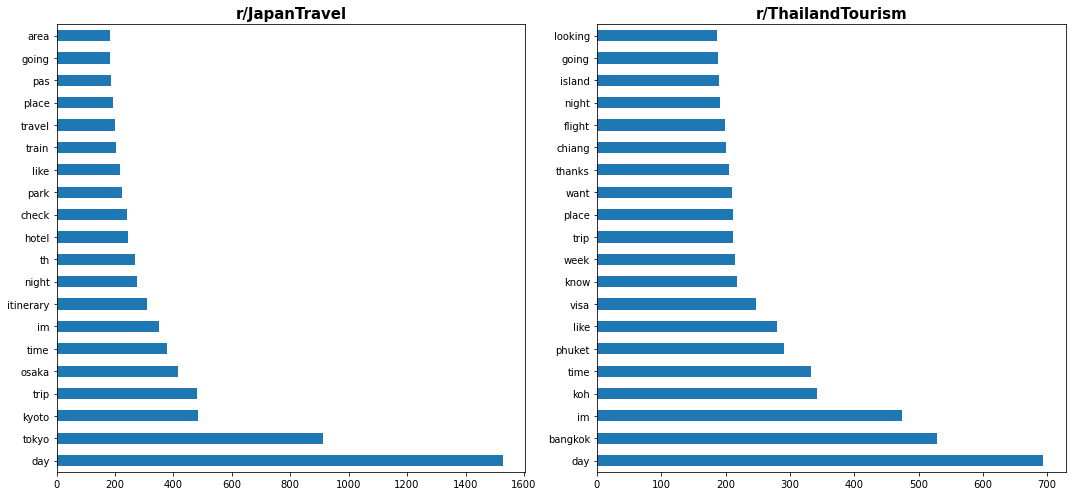

In [20]:
word_freq_plot('cvec', 1, 20)

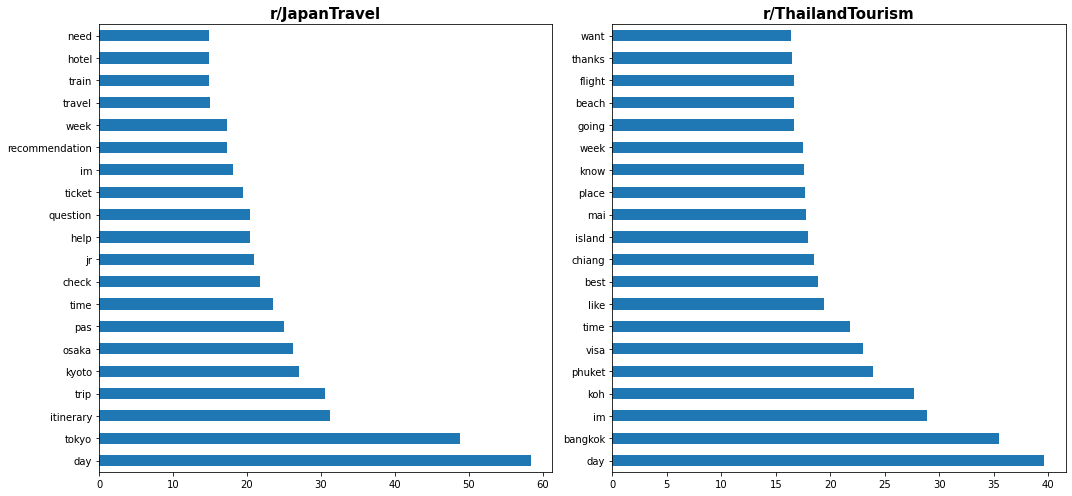

In [21]:
word_freq_plot('tvec', 1, 20)

**Bi-gram Plot**

- Similar observations are seen for the bi-gram plot word frequency, using both count and TFID vectorizer

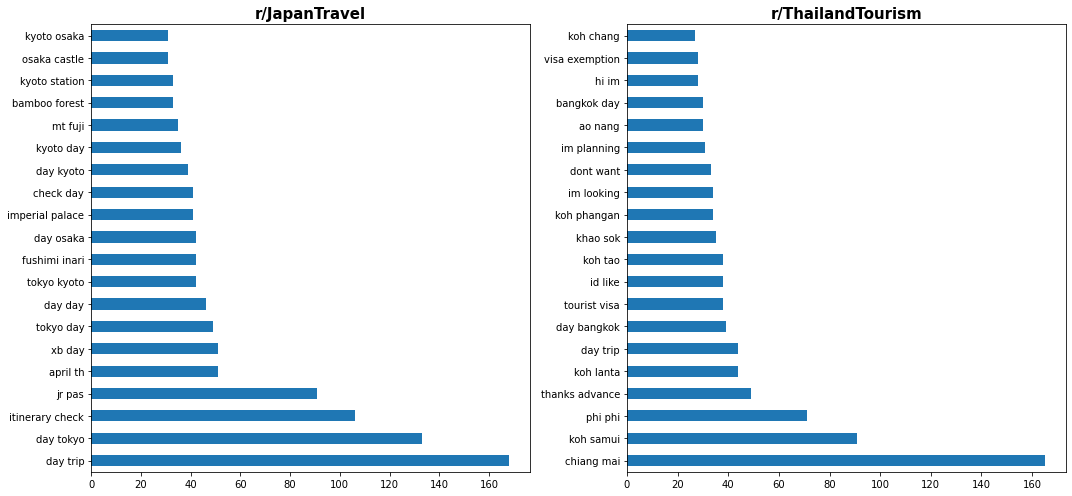

In [22]:
word_freq_plot('cvec', 2, 20)

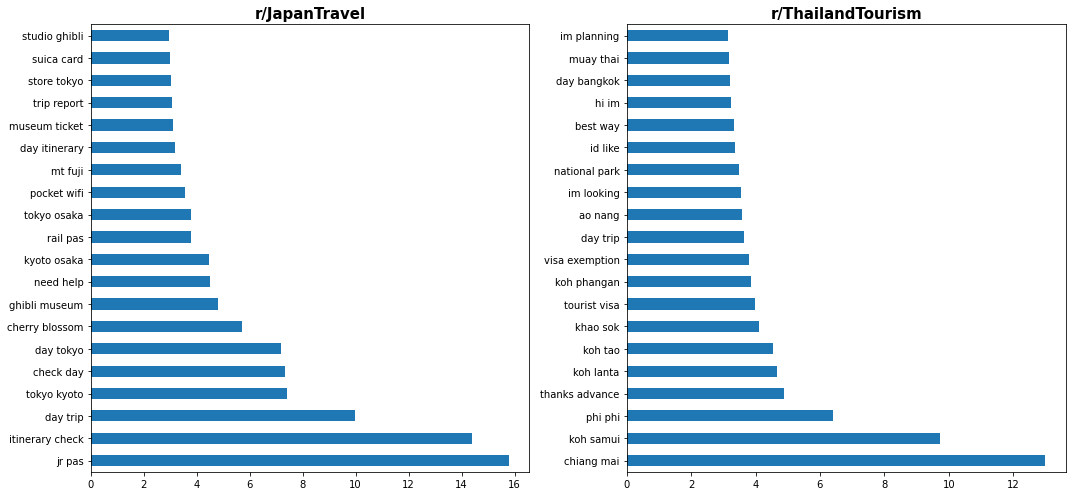

In [23]:
word_freq_plot('tvec', 2, 20)

**Tri-gram Plot**

- Similar observations are seen for the tri-gram plot word frequency, using both count and TFID vectorizer

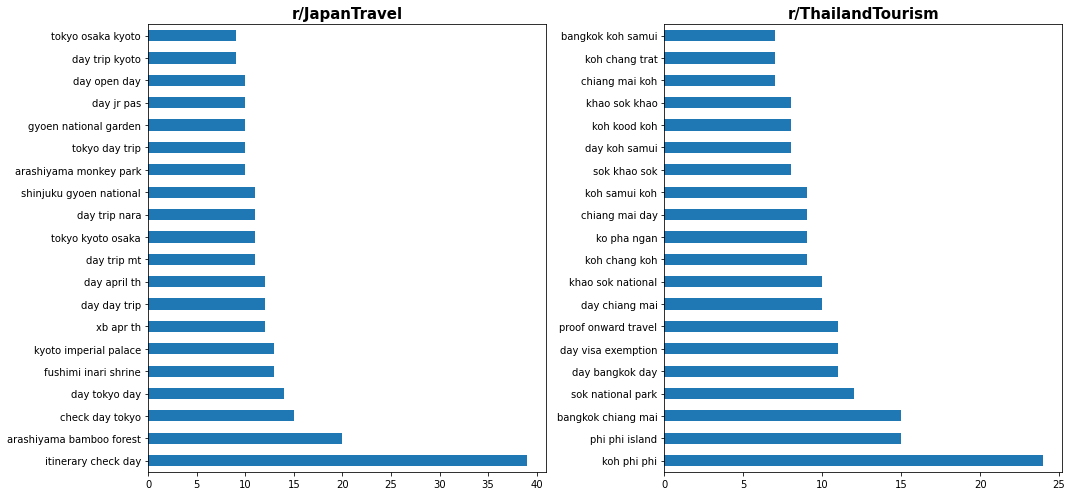

In [24]:
word_freq_plot('cvec', 3, 20)

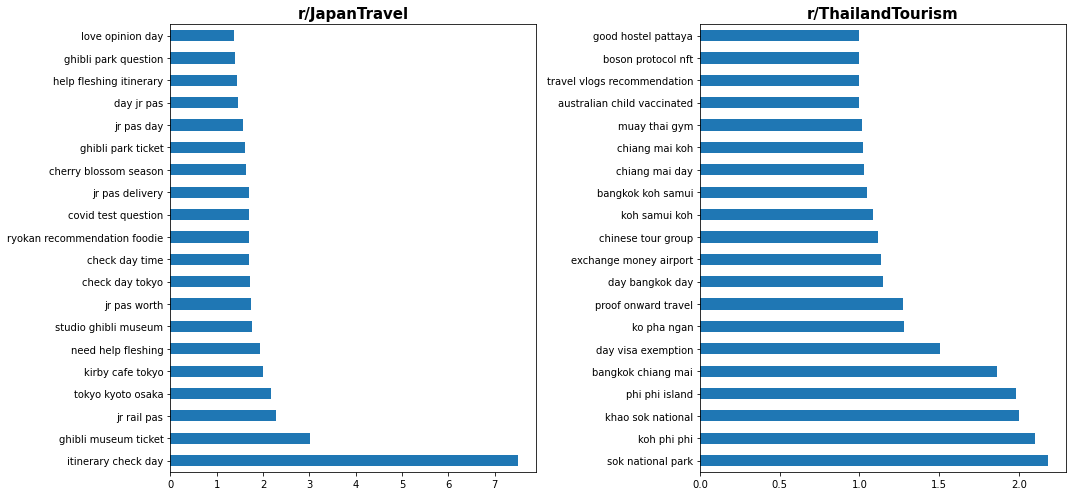

In [25]:
word_freq_plot('tvec', 3, 20)

In [26]:
#pass in additional list of stopwords with little/no significance or common places/cities of interest
stop_list = ['japan', 'thailand', 'day', 'bangkok', 'phuket', 'tokyo', 'kyoto', 'osaka', 'thai', 'japanese', 
             'chiang', 'mai', 'koh', 'samui', 'pattaya', 'krabi', 'hiroshima', 'xb', 'trip', 'like', 
             'im', 'hi', 'thanks', 'ive', 'want', 'going', 'looking', 'need', 'travel', 'time', 'best', 'week', 
             'know', 'th', 'help', 'days']
def stop_word1(info):
    word_stops = stopwords.words("english") + stop_list
    stop = [word.lower() for word in info if word.isalpha() and word.lower() not in word_stops]
    return stop

In [27]:
#re-apply tokenize function and apply updated stopword function with new stopwords defined above, join them back
#to combined string for vectorization eventually
reddit['new_text'] = reddit['new_text'].apply(lambda x: tokenize(x))
reddit['new_text'] = reddit['new_text'].apply(lambda x: stop_word1(x))
reddit['new_text'] = reddit['new_text'].apply(lambda x: join_list(x))

**Uni-gram plot: After filtering**

- After running the additional filter of stopwords, the list of top words in each of the 2 subreddits become more distinct with better significance towards the 2 countries when considered as a holiday desination. Words such as 'train', 'park', 'station', 'shrine', 'museum' are commonly associated with the sights and transportation Japan, while 'beach', 'islands', 'visa' are associated when travellers plan for their vacation to Thailand.

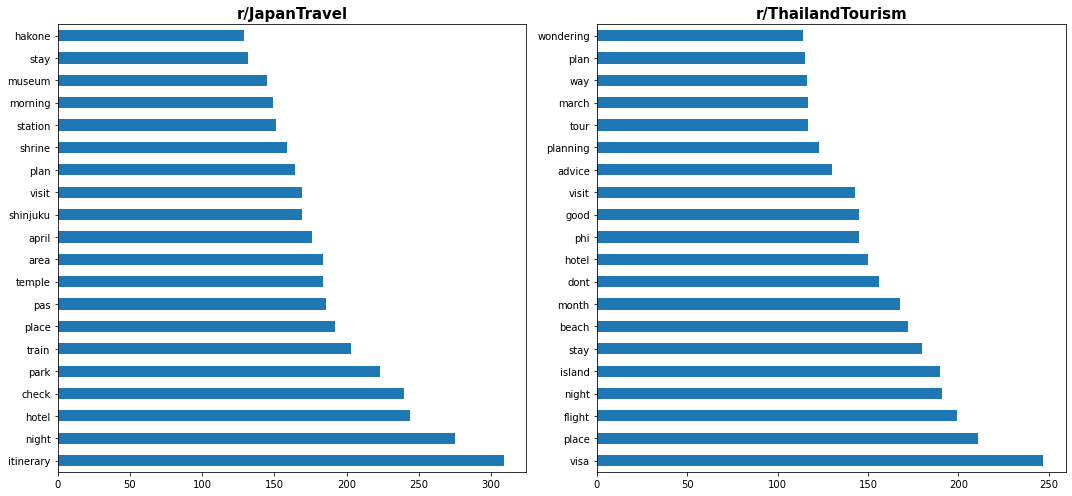

In [28]:
word_freq_plot('cvec', 1, 20)

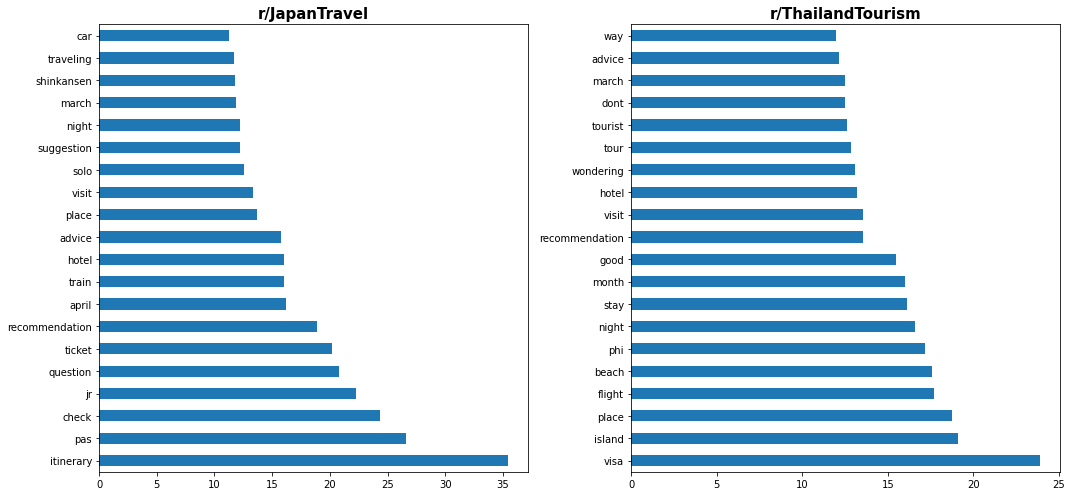

In [29]:
word_freq_plot('tvec', 1, 20)

**Bi-gram plot: After filtering**

- Top Bi-gram words reveal noun words surrounding places, transportations and entry requirements that have stronger association with Japan and Thailand respectively as compared to those observed in the Uni-gram plot.

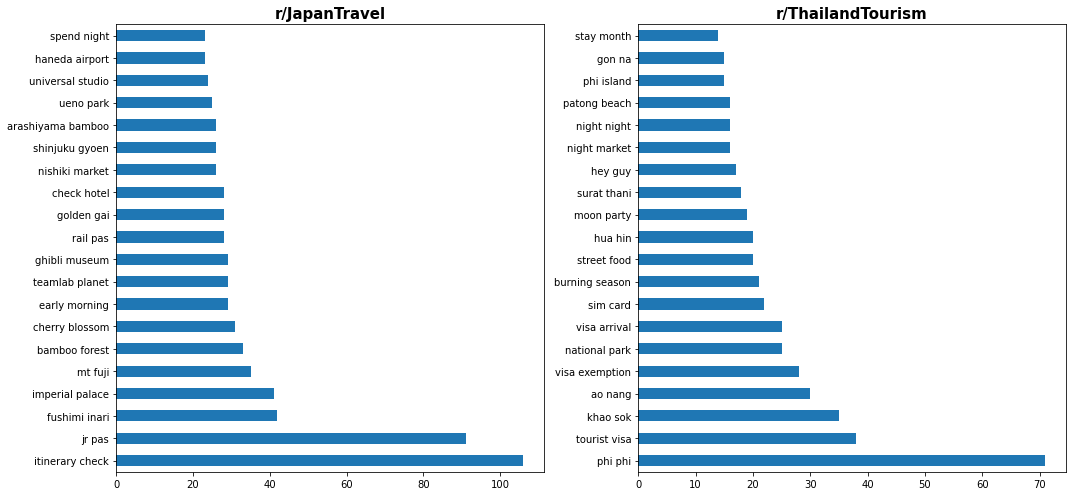

In [30]:
word_freq_plot('cvec', 2, 20)

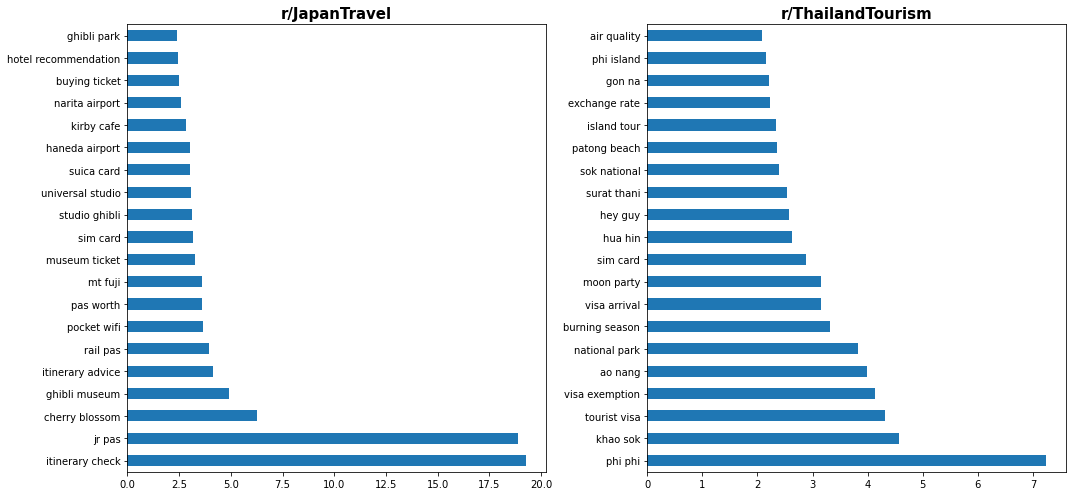

In [31]:
word_freq_plot('tvec', 2, 20)

**Tri-gram plot: After filtering**

- Top Tri-gram words are observed to be similar to that echoed in the Bi-gram plot with clearer references towards commonly visited places in both Japan and Thailand. However, we hypothesize that these words will not have much impact towards the model score as they are mostly noun-centric

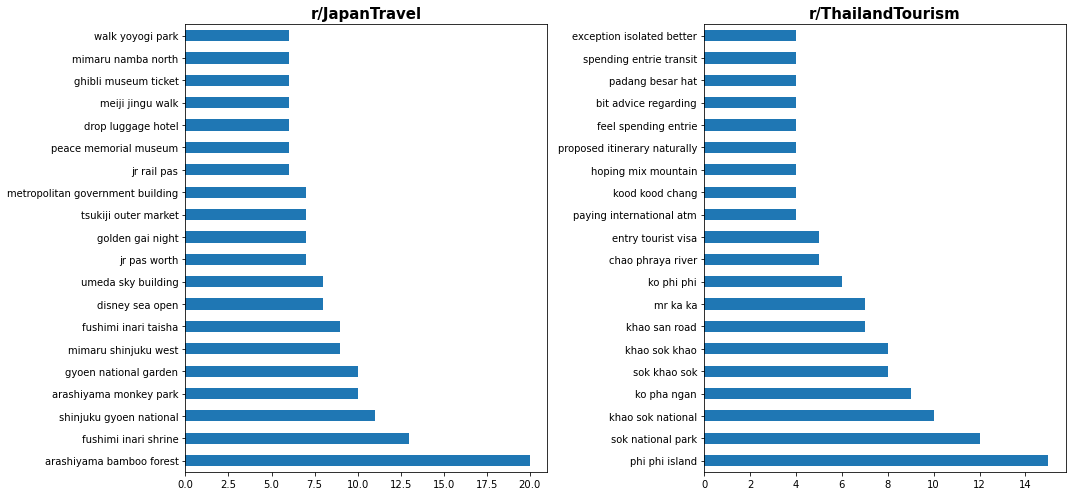

In [32]:
word_freq_plot('cvec', 3, 20)

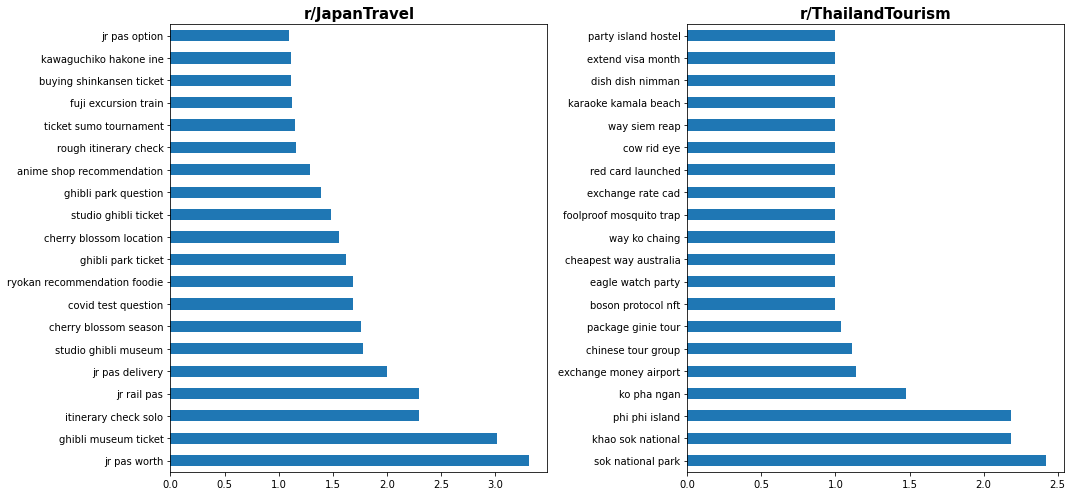

In [33]:
word_freq_plot('tvec', 3, 20)

In [34]:
#Instantiate Sentiment Analyzer
sent = SentimentIntensityAnalyzer()

#Get the sentiment ratings for various categoris
for sent_rating in ['neg', 'neu', 'pos', 'compound']:
    reddit[sent_rating] = reddit['new_text'].apply(lambda x: sent.polarity_scores(x)[sent_rating])

r/JapanTravel mean neg sentiment score: 0.03144774688398853
r/ThailandTourism mean neg sentiment score: 0.09145991172733518
r/JapanTravel mean neu sentiment score: 0.8788437200383503
r/ThailandTourism mean neu sentiment score: 0.1778968773465157
r/JapanTravel mean pos sentiment score: 0.08586673058485135
r/ThailandTourism mean pos sentiment score: 0.14328751305289045
r/JapanTravel mean compound sentiment score: 0.20677881112176422
r/ThailandTourism mean compound sentiment score: 0.3832415795466402


r/JapanTravel mean neg sentiment score : 0.054269157088122605
r/ThailandTourism mean neg sentiment score: 0.08956779874626551
r/JapanTravel mean neu sentiment score : 0.7889818007662845
r/ThailandTourism mean neu sentiment score: 0.1642137799825571
r/JapanTravel mean pos sentiment score : 0.15292241379310328
r/ThailandTourism mean pos sentiment score: 0.14441385717220181
r/JapanTravel mean compound sentiment score : 0.30569674329501934
r/ThailandTourism mean compound sentiment score: 0.4824

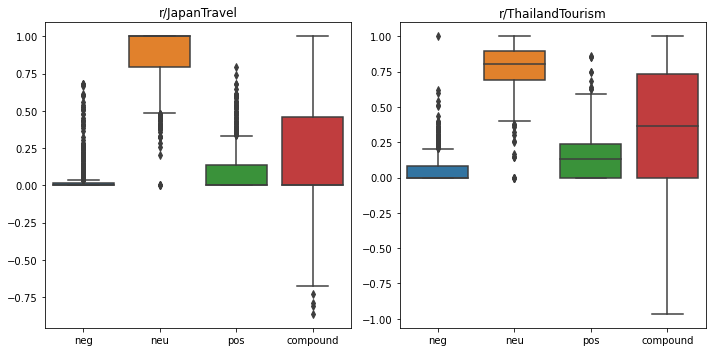

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(data=reddit[reddit["subreddit"] == "JapanTravel"], ax=ax[0])
sns.boxplot(data=reddit[reddit["subreddit"] == "ThailandTourism"], ax=ax[1])
ax[0].set_title('r/JapanTravel')
ax[1].set_title('r/ThailandTourism')
plt.tight_layout()



#print out mean and std dev of the sentiment values for JapanTravel and ThailandTourism
for sent_rating in ['neg', 'neu', 'pos', 'compound']:
    print(f'r/JapanTravel mean {sent_rating} sentiment score: {reddit[reddit["subreddit"] == "JapanTravel"][sent_rating].mean()}')
    print(f'r/ThailandTourism mean {sent_rating} sentiment score: {reddit[reddit["subreddit"] == "JapanTravel"][sent_rating].std()}')
    print('==========================')
print('\n')
for sent_rating in ['neg', 'neu', 'pos', 'compound']:
    print(f'r/JapanTravel mean {sent_rating} sentiment score : {reddit[reddit["subreddit"] == "ThailandTourism"][sent_rating].mean()}')
    print(f'r/ThailandTourism mean {sent_rating} sentiment score: {reddit[reddit["subreddit"] == "ThailandTourism"][sent_rating].std()}')
    print('==========================')

The sentiment scores across all categories in the 2 reddit subcategoris have similar distributions based on their mean and std dev values

<Figure size 1080x1080 with 0 Axes>

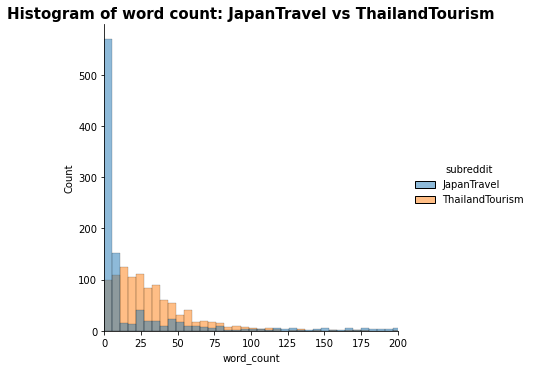

Mean word count for JapanTravel:   37.66922339405561
Mean word count for ThailandTourism: 34.30651340996169
Std dev word count for JapanTravel:   89.18689472163086
Std dev word count for ThailandTourism: 40.277107207609134


In [36]:
#Histogram plot of JapanTravel vs ThailandTourism
reddit['word_count'] = reddit['new_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15,15));
sns.displot(reddit, x='word_count', hue='subreddit', kde=False);
plt.title('Histogram of word count: JapanTravel vs ThailandTourism', fontsize=15, fontweight='bold');
plt.xlim(0,200);
plt.show();

print(f'Mean word count for JapanTravel:   {reddit[reddit["subreddit"] == "JapanTravel"]["word_count"].mean()}')
print(f'Mean word count for ThailandTourism: {reddit[reddit["subreddit"] == "ThailandTourism"]["word_count"].mean()}')
print('==========================')
print(f'Std dev word count for JapanTravel:   {reddit[reddit["subreddit"] == "JapanTravel"]["word_count"].std()}')
print(f'Std dev word count for ThailandTourism: {reddit[reddit["subreddit"] == "ThailandTourism"]["word_count"].std()}')

- Both r/JapanTravel and r/ThailandTourism have approximately similar mean word count. Both subreddits have skewed distributions towards the right

# Data Modelling

- Since our goal is to successfully classify incoming posts into the correct subreddit categories in a simplistic manner for our stakeholders to understand, we will be targeting to optimise the accuracy rate. Hence, accuracy score will be selected metric to be scored throughout the modelling process.

**Pre-processing**

In [37]:
#defining posts in JapanTravel to be 1, and ThailandTourism to be 0
reddit['subreddit'] = reddit['subreddit'].map(lambda x: 1 if x == 'JapanTravel' else 0)

In [38]:
#check distribution of subreddit texts
reddit['subreddit'].value_counts(normalize=True)

0    0.50024
1    0.49976
Name: subreddit, dtype: float64

In [39]:
X = reddit['new_text']
y = reddit['subreddit']

In [40]:
#Instantiate train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Model 1: Multinomial Naive Bayes (Count Vectorizer)

In [41]:
pipe = Pipeline([('cvec', CountVectorizer()), ('NB', MultinomialNB())])

pipe_params = {"cvec__max_features": [2000, 3000, 4000, 5000], "cvec__min_df": [2, 3],
                "cvec__max_df": [0.9, 0.95], "cvec__ngram_range": [(1,1), (1,2), (2,2), (2,3)], "NB__fit_prior": [True, False]}

In [42]:
gs1 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'NB__fit_prior': [True, False],
                         'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             scoring='accuracy')

In [43]:
gs1.best_params_

{'NB__fit_prior': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [44]:
print(f'best score through grid search: {gs1.best_score_}')

best score through grid search: 0.8083067092651757


In [45]:
print(f'Accuracy score from train: {gs1.score(X_train, y_train)}')
print(f'Accuracy score from testing: {gs1.score(X_test, y_test)}')

Accuracy score from train: 0.8824281150159744
Accuracy score from testing: 0.8639846743295019


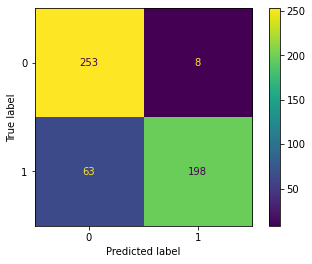

In [46]:
#predict test data
y_pred1 = gs1.predict(X_test)

#create confusion matrix
cm1 = confusion_matrix(y_test, y_pred1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
disp1 = ConfusionMatrixDisplay(cm1)
disp1.plot()

In [47]:
model_1 = {}
model_1['accuracy'] = accuracy_score(y_test, y_pred1)
model_1['precision'] = precision_score(y_test, y_pred1)
model_1['recall'] = recall_score(y_test, y_pred1)
model_1['f1'] = f1_score(y_test, y_pred1)
model_1['specificity'] = tn / (tn+fp)
model_1

{'accuracy': 0.8639846743295019,
 'precision': 0.9611650485436893,
 'recall': 0.7586206896551724,
 'f1': 0.8479657387580299,
 'specificity': 0.9693486590038314}

low recall -> high false negative: some of the thailand posts are incorrectly predicted to be japan posts

### Model 2: Multinomial Naive Bayes (TFIDF)

In [48]:
pipe = Pipeline([('tvec', TfidfVectorizer()), ('NB', MultinomialNB())])

pipe_params = {"tvec__max_features": [2000, 3000, 4000, 5000], "tvec__min_df": [2, 3],
                "tvec__max_df": [0.9, 0.95], "tvec__ngram_range": [(1,1), (1,2), (2,2), (2,3)], "NB__fit_prior": [True, False]}

In [49]:
gs2 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'NB__fit_prior': [True, False],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             scoring='accuracy')

In [50]:
gs2.best_params_

{'NB__fit_prior': False,
 'tvec__max_df': 0.9,
 'tvec__max_features': 3000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [51]:
print(f'best score through grid search: {gs2.best_score_}')

best score through grid search: 0.8351437699680512


In [52]:
print(f'Accuracy score from train: {gs2.score(X_train, y_train)}')
print(f'Accuracy score from testing: {gs2.score(X_test, y_test)}')

Accuracy score from train: 0.923961661341853
Accuracy score from testing: 0.8601532567049809


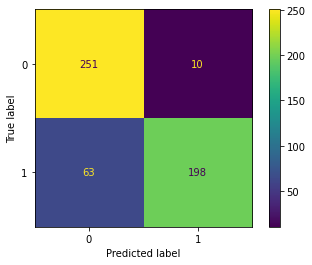

In [53]:
#predict test data
y_pred2 = gs2.predict(X_test)

#create confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
disp2 = ConfusionMatrixDisplay(cm2)
disp2.plot()

In [54]:
model_2 = {}
model_2['accuracy'] = accuracy_score(y_test, y_pred2)
model_2['precision'] = precision_score(y_test, y_pred2)
model_2['recall'] = recall_score(y_test, y_pred2)
model_2['f1'] = f1_score(y_test, y_pred2)
model_2['specificity'] = tn / (tn+fp)
model_2

{'accuracy': 0.8601532567049809,
 'precision': 0.9519230769230769,
 'recall': 0.7586206896551724,
 'f1': 0.8443496801705757,
 'specificity': 0.9616858237547893}

slightly higher then cvec, but still low recall -> high false negative: some of the thailand posts are incorrectly predicted to be japan posts

### Model 3: Logistic Regression (TFIDF)

In [55]:
pipe = Pipeline([('tvec', TfidfVectorizer()), ('logreg', LogisticRegression())])

pipe_params = {"tvec__max_features": [2000, 3000, 4000, 5000], "tvec__min_df": [2, 3],
                "tvec__max_df": [0.9, 0.95], "tvec__ngram_range": [(1,1), (1,2), (2,2), (2,3)], 
               "logreg__penalty": ['l1', 'l2'], "logreg__solver": ['saga'], 
               "logreg__C": [0.001, 0.01, 0.5, 1.0], "logreg__max_iter": [300], "logreg__random_state": [42]}

In [56]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('logreg', LogisticRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'logreg': LogisticRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': No

In [57]:
gs3 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.5, 1.0],
                         'logreg__max_iter': [300],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__random_state': [42],
                         'logreg__solver': ['saga'],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             scoring='accuracy')

In [58]:
gs3.best_params_

{'logreg__C': 1.0,
 'logreg__max_iter': 300,
 'logreg__penalty': 'l2',
 'logreg__random_state': 42,
 'logreg__solver': 'saga',
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [59]:
print(f'Accuracy score from train: {gs3.score(X_train, y_train)}')
print(f'Accuracy score from testing: {gs3.score(X_test, y_test)}')

Accuracy score from train: 0.954632587859425
Accuracy score from testing: 0.8563218390804598


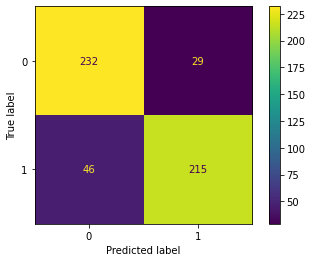

In [60]:
#predict test data
y_pred3 = gs3.predict(X_test)

#create confusion matrix
cm3 = confusion_matrix(y_test, y_pred3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
disp3 = ConfusionMatrixDisplay(cm3)
disp3.plot()

In [61]:
model_3 = {}
model_3['accuracy'] = accuracy_score(y_test, y_pred3)
model_3['precision'] = precision_score(y_test, y_pred3)
model_3['recall'] = recall_score(y_test, y_pred3)
model_3['f1'] = f1_score(y_test, y_pred3)
model_3['specificity'] = tn / (tn+fp)
model_3

{'accuracy': 0.8563218390804598,
 'precision': 0.8811475409836066,
 'recall': 0.8237547892720306,
 'f1': 0.8514851485148515,
 'specificity': 0.8888888888888888}

### Model 4: DecisionTree (TFIDF)

In [62]:
pipe = Pipeline([('tvec', TfidfVectorizer()), ('dt', DecisionTreeClassifier())])

pipe_params = {"tvec__max_features": [2000, 3000, 4000, 5000], "tvec__min_df": [2, 3],
                "tvec__max_df": [0.9, 0.95], "tvec__ngram_range": [(1,1), (1,2), (2,2), (2,3)], "dt__max_depth": [3, 5, 7], 
               "dt__ccp_alpha": [0.001, 0.01, 0.5, 1.0], "dt__min_samples_leaf": [3, 5, 7], 
               'dt__min_samples_split': [3, 5, 9], 'dt__random_state': [42]}

In [63]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('dt', DecisionTreeClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'dt': DecisionTreeClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'gini',
 'dt__max_depth': None,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 

In [64]:
gs4 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0.001, 0.01, 0.5, 1.0],
                         'dt__max_depth': [3, 5, 7],
                         'dt__min_samples_leaf': [3, 5, 7],
                         'dt__min_samples_split': [3, 5, 9],
                         'dt__random_state': [42], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             scoring='accuracy')

In [65]:
gs4.best_params_

{'dt__ccp_alpha': 0.001,
 'dt__max_depth': 7,
 'dt__min_samples_leaf': 7,
 'dt__min_samples_split': 3,
 'dt__random_state': 42,
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [66]:
print(f'best score through grid search: {gs4.best_score_}')

best score through grid search: 0.6543130990415336


In [67]:
print(f'Accuracy score from train: {gs4.score(X_train, y_train)}')
print(f'Accuracy score from testing:{gs4.score(X_test, y_test)}')

Accuracy score from train: 0.6753993610223642
Accuracy score from testing:0.6743295019157088


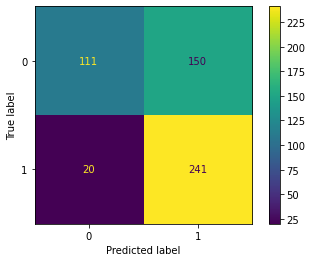

In [68]:
#predict test data
y_pred4 = gs4.predict(X_test)

#create confusion matrix
cm4 = confusion_matrix(y_test, y_pred4)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()
disp4 = ConfusionMatrixDisplay(cm4)
disp4.plot()

In [69]:
model_4 = {}
model_4['accuracy'] = accuracy_score(y_test, y_pred4)
model_4['precision'] = precision_score(y_test, y_pred4)
model_4['recall'] = recall_score(y_test, y_pred4)
model_4['f1'] = f1_score(y_test, y_pred4)
model_4['specificity'] = tn / (tn+fp)
model_4

{'accuracy': 0.6743295019157088,
 'precision': 0.6163682864450127,
 'recall': 0.9233716475095786,
 'f1': 0.7392638036809814,
 'specificity': 0.42528735632183906}

### Model 5: RandomForest (TFIDF)

In [70]:
pipe = Pipeline([('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())])

pipe_params = {"tvec__max_features": [2000, 3000, 4000, 5000], "tvec__min_df": [2, 3],
                "tvec__max_df": [0.9, 0.95], "tvec__ngram_range": [(1,1), (1,2), (2,2), (2,3)], "rf__max_depth": [3, 5, 7], 
               "rf__ccp_alpha": [0.001, 0.01, 0.5, 1.0], "rf__min_samples_leaf": [3, 5, 7], 
               'rf__min_samples_split': [3, 5, 9], 'rf__random_state': [42]}

In [71]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [72]:
gs5 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__ccp_alpha': [0.001, 0.01, 0.5, 1.0],
                         'rf__max_depth': [3, 5, 7],
                         'rf__min_samples_leaf': [3, 5, 7],
                         'rf__min_samples_split': [3, 5, 9],
                         'rf__random_state': [42], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]},
             scoring='accuracy')

In [73]:
gs5.best_params_

{'rf__ccp_alpha': 0.001,
 'rf__max_depth': 5,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 3,
 'rf__random_state': 42,
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [74]:
print(f'best score through grid search: {gs5.best_score_}')

best score through grid search: 0.807667731629393


In [75]:
print(f'Accuracy score from train: {gs5.score(X_train, y_train)}')
print(f'Accuracy score from testing:{gs5.score(X_test, y_test)}')

Accuracy score from train: 0.8242811501597445
Accuracy score from testing:0.8103448275862069


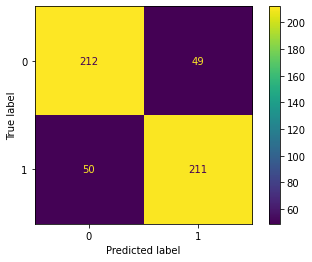

In [76]:
#predict test data
y_pred5 = gs5.predict(X_test)

#create confusion matrix
cm5 = confusion_matrix(y_test, y_pred5)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred5).ravel()
disp5 = ConfusionMatrixDisplay(cm5)
disp5.plot()

In [77]:
model_5 = {}
model_5['accuracy'] = accuracy_score(y_test, y_pred5)
model_5['precision'] = precision_score(y_test, y_pred5)
model_5['recall'] = recall_score(y_test, y_pred5)
model_5['f1'] = f1_score(y_test, y_pred5)
model_5['specificity'] = tn / (tn+fp)
model_5

{'accuracy': 0.8103448275862069,
 'precision': 0.8115384615384615,
 'recall': 0.8084291187739464,
 'f1': 0.8099808061420346,
 'specificity': 0.8122605363984674}

### Model 6: GradientBoosting (TFIDF)

In [78]:
pipe = Pipeline([('tvec', TfidfVectorizer()), ('gb', GradientBoostingClassifier())])

pipe_params = {"tvec__max_features": [2000, 3000, 4000, 5000], "tvec__min_df": [2, 3],
                "tvec__max_df": [0.9, 0.95], "tvec__ngram_range": [(1,1), (1,2)], "gb__max_depth": [3, 5, 7], 
               "gb__learning_rate": [0.001, 0.01, 0.5, 1.0], "gb__min_samples_leaf": [3, 5, 7], 
               'gb__n_estimators': [100, 125, 150], 'gb__random_state': [42]}

In [79]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('gb', GradientBoostingClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'gb': GradientBoostingClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'deviance',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.

In [80]:
gs6 = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='accuracy') 
gs6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('gb', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gb__learning_rate': [0.001, 0.01, 0.5, 1.0],
                         'gb__max_depth': [3, 5, 7],
                         'gb__min_samples_leaf': [3, 5, 7],
                         'gb__n_estimators': [100, 125, 150],
                         'gb__random_state': [42], 'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [81]:
gs6.best_params_

{'gb__learning_rate': 0.5,
 'gb__max_depth': 7,
 'gb__min_samples_leaf': 7,
 'gb__n_estimators': 100,
 'gb__random_state': 42,
 'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [82]:
print(f'best score through grid search: {gs6.best_score_}')

best score through grid search: 0.8012779552715654


In [83]:
print(f'F1 score from train: {gs6.score(X_train, y_train)}')
print(f'F1 score from testing:{gs6.score(X_test, y_test)}')

F1 score from train: 0.9859424920127795
F1 score from testing:0.8180076628352491


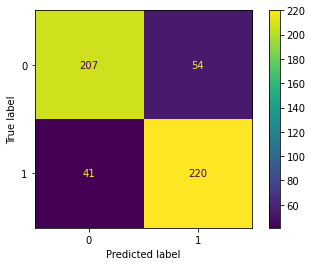

In [84]:
#predict test data
y_pred6 = gs6.predict(X_test)

#create confusion matrix
cm6 = confusion_matrix(y_test, y_pred6)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred6).ravel()
disp6 = ConfusionMatrixDisplay(cm6)
disp6.plot()

In [85]:
model_6 = {}
model_6['accuracy'] = accuracy_score(y_test, y_pred6)
model_6['precision'] = precision_score(y_test, y_pred6)
model_6['recall'] = recall_score(y_test, y_pred6)
model_6['f1'] = f1_score(y_test, y_pred6)
model_6['specificity'] = tn / (tn+fp)
model_6

{'accuracy': 0.8180076628352491,
 'precision': 0.8029197080291971,
 'recall': 0.842911877394636,
 'f1': 0.8224299065420559,
 'specificity': 0.7931034482758621}

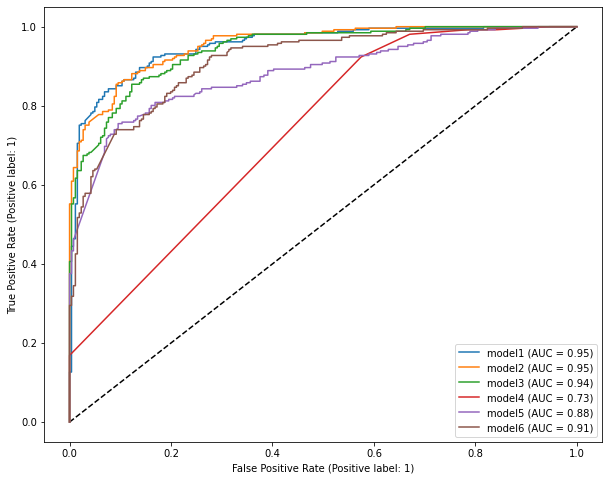

In [86]:
gs_list = [gs1, gs2, gs3, gs4, gs5, gs6]
fig, ax = plt.subplots(figsize=(10,8))
plt.plot([0, 1], [0, 1], "k--")
for i, model in enumerate(gs_list):
    RocCurveDisplay.from_estimator(model,
                                   X_test,
                                   y_test,
                                   ax=ax,
                                   name=f'model{i+1}')

- The ROC-AUC curve indicates the model's ability to correctly classify the incoming posts into r/JapanTravel and r/ThailandTourism. From the above ROC-AUC plot, we can observe that model 1 and model 2 excelled in classifying the incoming posts into the 2 different subreddit categories

| **Model No.**| **Model** | **Accuracy** | **Precision** | **Recall** | **F1** | **AUC** |
| --- | --- | ---| ---| ---| ---| ---|
| 1 | Multinomial Naive Bayes(CountVectorizer) | 0.864 | 0.961 | 0.759 | 0.848 | 0.95  |
| 2 | Multinomial Naive Bayes(TFIDF) | 0.860 | 0.952 | 0.759 | 0.844 | 0.95    |
| 3 | **Logistic Regression(TFIDF)** | **0.856** | 0.881 | 0.824 | 0.851 | **0.94** |
| 4 | Decision Tree(TFIDF) | 0.674 | 0.616 | 0.923 | 0.739 |  0.73 |
| 5 | Random Forest(TFIDF) | 0.810 | 0.812 | 0.808 | 0.810 |  0.88 |
| 6 | Gradient Boosting (TFIDF) | 0.818 | 0.803 | 0.843 | 0.822 |  0.91 |

| **Model No.**| **Model** | **Train Accuracy** | **Test Accuracy** |
| --- | --- | ---| ---|
| 1 | Multinomial Naive Bayes(CountVectorizer) | 0.882 | 0.864 |
| 2 | Multinomial Naive Bayes(TFIDF) | 0.924| 0.860 |
| 3 | Logistic Regression(TFIDF) | 0.955 | 0.856 |
| 4 | Decision Tree(TFIDF) | 0.675 | 0.674 |
| 5 | Random Forest(TFIDF) | 0.824 | 0.810 |
| 6 | Gradient Boosting (TFIDF) | 0.986 | 0.818 |

- From the summary tables of the various classification metrics that we have compiled on the different models, it can be observed that Model 1: Multinomial Naive Bayes(Count Vectorizer), Model 2: Multinomial Naive Bayes(TFIDF) and Model 3: Logistic Regression(TFIDF) performed the best in terms of accuracy. However, the final model that we will be selecting for potential deployment to production will be model 3. 

- Although the Logistic Regression(TFIDF) model shows the most consistent scores across all the classification metrics, it tends to overfit a little on the test data. Comparatively, the Multinomial Naive Bayes(TFIDF) model shows little to no overfitting. Both these 2 models can have their hyperparameters fine-tuned respectivey as well. Hence, based on these reasonings, we can hypothesize that the performance for Multinomial Naive Bayes(TFIDF) could be more durable for deployment over a longer term

Although Multinomial Naive Bayes(TFIDF) shows similar degree of overfitting on the test data as compared to Logistic Regression(TFIDF), its other classification metrics are not as consistent throughout. This can be inferred from the confusion matrix in both the CountVectorizer and TFID versions of Naive Bayes model having higher False Negatives(Misclassification of ThailandTourism). In this scenario where we want to optimise our binary classification model to reduce the misclassification rate for both classes together so as to correctly classify all incoming posts into JapanTravel and ThailandTourism, the Logistic Regression(TFIDF) model will be the present goto recommendation

## Model Evaluation

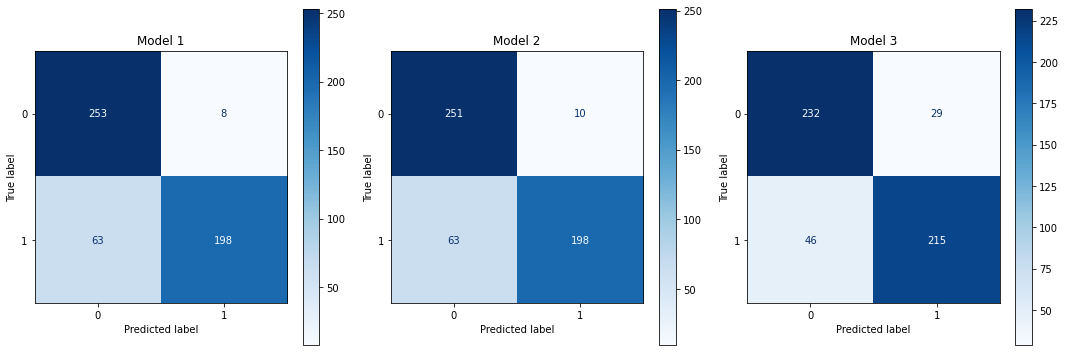

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, cm in enumerate([cm1, cm2, cm3]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i], values_format='d', cmap='Blues')
    axs[i].set_title(f'Model {i+1}')

plt.tight_layout()
plt.show()

- Continuing on from our previous explanation on the summary metrics of the previous models, we can see that model 3 (Logistic Regression TFIDF) has a balanced amount of false positives and false negatives as compared to the Multinomial Naive Bayes models (Model 1 and Model 2). Taking into the context of this business problem, since our goal is to optimise the reduction of incoming posts having misclassified into r/JapanTravel and r/ThailandTourism together through a simplistic approach, as well as considering the model's performance in predicting correctly on classifying unseen posts in the long term, it would be ideal to select Model 3 over Model 2/Model 1 when considering for production deployment

In [89]:
print(f'Total no. of features selected by Model 3: {gs3.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 3: 5000


In [90]:
print(f'Total no. of features selected by Model 2: {gs2.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 2: 3000


In [91]:
print(f'Total no. of features selected by Model 1: {gs1.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 1: 3507


In [92]:
print(f'Total no. of features selected by Model 4: {gs4.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 4: 2000


In [93]:
print(f'Total no. of features selected by Model 5: {gs5.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 5: 5000


In [94]:
print(f'Total no. of features selected by Model 6: {gs6.best_estimator_[0].get_feature_names_out().shape[0]}')

Total no. of features selected by Model 6: 2000


| **Model No.**| **Model** | **No. of Features** |
| --- | --- | ---|
| 1 | Multinomial Naive Bayes(CountVectorizer) | 3507 |
| 2 | Multinomial Naive Bayes(TFIDF) | 3000 |
| 3 | Logistic Regression(TFIDF) | 5000 |
| 4 | Decision Tree(TFIDF) | 2000 |
| 5 | Random Forest(TFIDF) | 5000 |
| 6 | Gradient Boosting (TFIDF) | 2000 |

Logistic Regression and RandomForest models have selected the most features to be used in the modelling process during the hyperparameter tuning by gridsearch. Although they have the same features, the logistic regression model's accuracy maringally outperforms that of the RandomForest model. However, the RandomForest model can still be considered a potential model in cases where the logistic regression might fail, such as if the training dataset consist of imbalanced binary outcomes. In this situation, one would be wise to select RandomForest model as its classification metrics are also consistent throughout.

In [95]:
#Extract the word feature names and coefficient weights from model 3
feature_names = gs3.best_estimator_.named_steps['tvec'].get_feature_names_out()
log_coefs = gs3.best_estimator_.named_steps['logreg'].coef_[0]

In [96]:
#put the top word feature importance into dataframe
lr_result = pd.DataFrame(log_coefs, index = feature_names)
lr_result.columns = ['coef_weights']
lr_result.sort_values(by = "coef_weights", ascending = False).head(15)

,coef_weights
itinerary,2.342781
pas,2.031222
shinkansen,1.822851
haneda,1.762832
jr,1.740959
question,1.588221
hakone,1.449264
jr pas,1.433910
ghibli,1.432718
ticket,1.369524


In [97]:
lr_result.sort_values(by = "coef_weights", ascending = False).tail(15)

,coef_weights
wondering,-1.111727
patong,-1.117239
songkran,-1.160475
party,-1.194796
guy,-1.227722
go,-1.234247
tourist,-1.261006
khao,-1.341361
ko,-1.370963
tao,-1.476033


In [105]:
print(f'Probability odds of successful classification in r/JapanTravel for {lr_result.sort_values(by="coef_weights", ascending=False).index[0]} is {round(np.exp(lr_result.sort_values(by="coef_weights", ascending=False)["coef_weights"][0]), 4)}') 

print(f'Probability odds of successful classification in r/ThailandTourism for {lr_result.sort_values(by="coef_weights", ascending=False).index[-1]} is {round(np.exp(lr_result.sort_values(by="coef_weights", ascending=False)["coef_weights"][-1]), 4)}')


Probability odds of successful classification in r/JapanTravel for itinerary is 10.4101
Probability odds of successful classification in r/ThailandTourism for beach is 0.0977


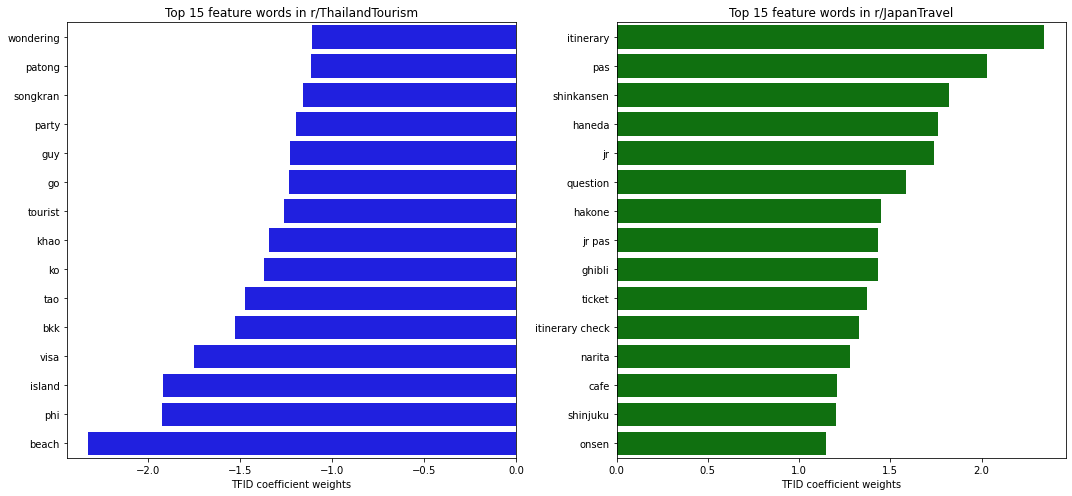

In [106]:
#sort the top 15 important word features used for model3 and plot them in descending order
desc = lr_result.sort_values(by = "coef_weights", ascending = False).head(15)
asc = lr_result.sort_values(by = "coef_weights", ascending = False).tail(15)

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.barplot(data=desc, y=desc.index, x='coef_weights', orient='h', color='green', ax=axs[1])
axs[1].set_title('Top 15 feature words in r/JapanTravel')
axs[1].set_xlabel('TFID coefficient weights')

sns.barplot(data=asc, y=asc.index, x='coef_weights', orient='h', color='blue', ax=axs[0])
axs[0].set_title('Top 15 feature words in r/ThailandTourism')
axs[0].set_xlabel('TFID coefficient weights')

plt.tight_layout()
plt.show()

From the above feature importance plots of the top words chosen by the Logistic Regression model during modelling, we can infer that the model has successfully predicted the class on incoming unseen posts into the correct categories. These are examples of intepretation on how we can infer how each of the top feature words will impact the model's ability to classify into either **r/JapanTravel** or **r/ThailandTourism**:

- 1 unit increase in new post having the word 'itinerary' increases the odds by 10.4101 of having it to be successfully classified in **r/JapanTravel**, holding all other selected word features in the model constant

- 1 unit increase in new post having the word 'beach' increases the odds by 0.0977 of having it to be successfully classified in **r/ThailandTourism**, holding all other selected word features in the model constant

## Conclusion

- We have successfully built a novel NLP classifier model that is able to classify incoming unseen travel posts into subreddit categories JapanTravel and ThailandTourism. This can be used for gathering feedbacks from past travellers about the important sights, places and activities that potential tourists tend to lookout for. The marketing and operations team will be able to effectively use them to conduct their research on the latest travel trends in these 2 countries and execute their campaign for the upcoming travel fair amidst the reopening of Singapore's international borders. Using the selected model (Model 3: Logistic Regression TFIDF), it scored **85.6%** on accuracy. These numbers indicate with good confidence that the prototype model can predict and classify well on incoming unseen posts. The results are encouraging and eligible for subsequent fine-tuning on broader dataset for validation in the future, in order to be potentially considered for actual deployment to production

## Recommendations

Although we have managed to successfully built a novel prototype NLP model that can be used to classify incoming unseen posts, there are definitely other ways which we can improve the model's predictive performance. Some of the possible ways are listed as such:

1. Duration of the dataset was scrapped with posts created from early to middle of March. Japan has seasonal sights that vary throughout the year, which will affect the type of words passed and selected by the model, which could impact the model's performance during different season cycles. It would be feasible to consider training on a larger validation dataset in groups of the various months corresponding to the different seasons


2. Employ Deep Learning techniques such as Recurrent Nerual Networks(RNN) or Transformer-models that have better predictability in processing sequential text data in order to better classify incoming unseen posts accurately in JapanTravel or ThailandTourism


3. The subreddits were taken from an international community due to lack of forum feedback from Singaporean travellers to these places. Hence, the validation dataset could be trained on text information taken from local subreddit forums instead when possible to validate its performance

### Sources:
1. https://www.straitstimes.com/life/travel/bangkok-tokyo-and-bali-are-top-year-end-destinations-among-singapore-travellers
2. https://www.travelandleisureasia.com/sg/news/year-end-travel-destinations-among-singapore-travellers/
3. https://www.straitstimes.com/singapore/singapore-will-lift-remaining-covid-19-border-restrictions-from-feb-13
4. https://www.v7labs.com/blog/transfer-learning-guide#h2